In [1]:
import os
import random
import json
from PIL import Image, ImageDraw, ImageFont

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from datasets import Dataset, Features, Value, ClassLabel, Sequence, Array2D, Array3D
from transformers import AutoProcessor, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import evaluate

RANDOM_STATE = 1992
random.seed(RANDOM_STATE)
TRAIN_DEV_SET_SIZE = 120

os.environ["TOKENIZERS_PARALLELISM"] = "false"

/Users/davidhajdu/Desktop/Projects/DocumentClassifier/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Filter out the train/dev set and create a Pandas DataFrame

In [2]:
def create_dataframe(root_folder):
    data = []
    
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file != '.DS_Store':
                target = os.path.basename(root)
                filename = file
                relative_path = os.path.relpath(os.path.join(root_folder, root, file), root_folder)
                data.append((filename, target, relative_path))
    
    df = pd.DataFrame(data, columns=['filename', 'target', 'relative_path'])
    return df

def sample_per_target(df):
    sampled_data = []
    groups = df.groupby('target')
    
    for target, group in groups:
        if len(group) >= TRAIN_DEV_SET_SIZE:
            sampled_data.append(group.sample(n=TRAIN_DEV_SET_SIZE, random_state=RANDOM_STATE))
        else:
            sampled_data.append(group)
    
    sampled_df = pd.concat(sampled_data)
    return sampled_df

In [4]:
df = create_dataframe('docs-sm')

train_df = sample_per_target(df)

train_df = shuffle(train_df)
train_df = train_df.reset_index()

df.to_csv('raw_dataset.csv', index=False)
train_df.to_csv('train_dataset.csv', index=False)

# Collect all labels and create id2label and label2id dicts
labels = list(set(train_df['target'].to_list()))
id2label = {k: v for k,v in enumerate(labels)}
label2id = {v: k for k,v in enumerate(labels)}

with open("labels.json", "w") as f:
    json.dump(labels, f)

with open("id2label.json", "w") as f:
    json.dump(id2label, f)

with open("label2id.json", "w") as f:
    json.dump(label2id, f)

train_df['enc_target'] = train_df.target.map(lambda x : label2id[x])
display(train_df)

,index,filename,target,relative_path,enc_target
0,2735,2028896921-a_2028896928.jpg,scientific_report,docs-sm/scientific_report/2028896921-a_2028896...,11
1,3950,0011925683.jpg,presentation,docs-sm/presentation/0011925683.jpg,13
2,631,522858540+-8542.jpg,handwritten,docs-sm/handwritten/522858540+-8542.jpg,6
3,1384,0000128669.jpg,letter,docs-sm/letter/0000128669.jpg,7
4,172,96377421.jpg,form,docs-sm/form/96377421.jpg,4
...,...,...,...,...,...
1915,988,2026311878.jpg,resume,docs-sm/resume/2026311878.jpg,15
1916,3064,50025339_50025349.jpg,scientific_publication,docs-sm/scientific_publication/50025339_500253...,10
1917,544,94140766.jpg,news_article,docs-sm/news_article/94140766.jpg,12
1918,3806,2062415985.jpg,presentation,docs-sm/presentation/2062415985.jpg,13


In [5]:
train_df['target'].value_counts()

target
scientific_report         120
presentation              120
handwritten               120
letter                    120
form                      120
memo                      120
resume                    120
scientific_publication    120
file_folder               120
specification             120
advertisement             120
email                     120
questionnaire             120
news_article              120
invoice                   120
budget                    120
Name: count, dtype: int64

Selected image class: handwritten


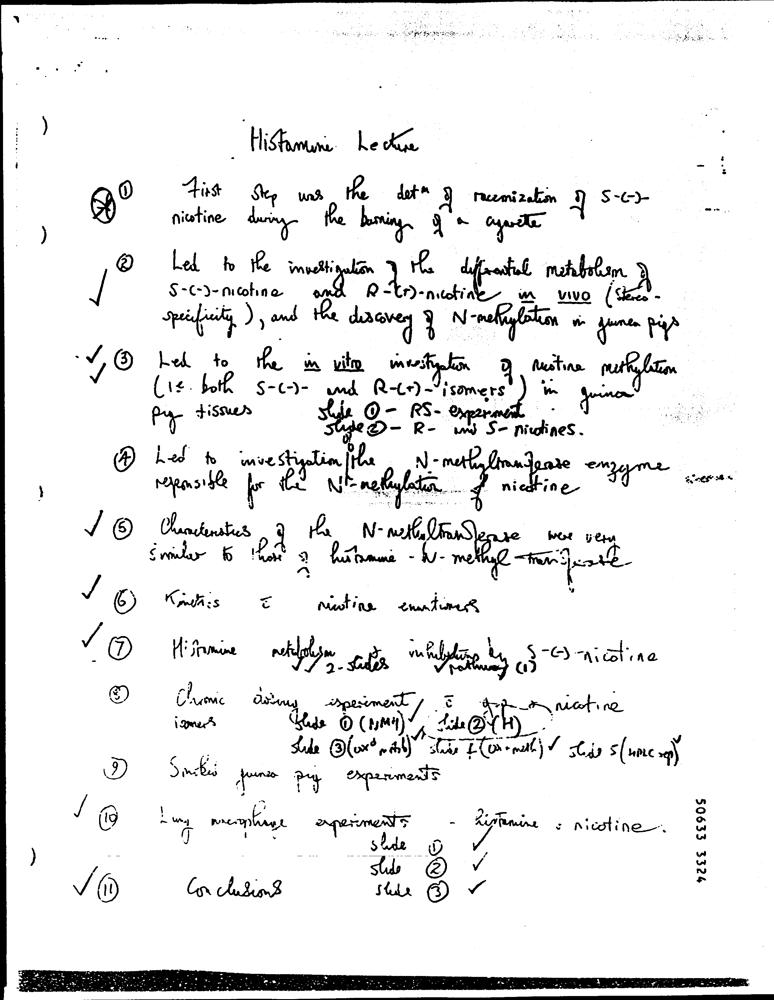

In [6]:
idx = 45
print(f'Selected image class: {train_df.loc[idx, 'target']}')

image = Image.open(train_df.loc[idx, 'relative_path'])
image = image.convert("RGB")
image

In [7]:
raw_dataset = Dataset.from_pandas(train_df, features=Features({'index': Value(dtype='int64', id=None),
                                                                'filename': Value(dtype='string', id=None),
                                                                'target':  ClassLabel(names=labels),
                                                                'relative_path': Value(dtype='string', id=None),
                                                                'enc_target': Value(dtype='int64', id=None)}))

raw_dataset

Dataset({
    features: ['index', 'filename', 'target', 'relative_path', 'enc_target'],
    num_rows: 1920
})

In [8]:
raw_dataset.features

{'index': Value(dtype='int64', id=None),
 'filename': Value(dtype='string', id=None),
 'target': ClassLabel(names=['file_folder', 'advertisement', 'questionnaire', 'specification', 'form', 'memo', 'handwritten', 'letter', 'invoice', 'email', 'scientific_publication', 'scientific_report', 'news_article', 'presentation', 'budget', 'resume'], id=None),
 'relative_path': Value(dtype='string', id=None),
 'enc_target': Value(dtype='int64', id=None)}

### Run OCR on images. Extract HF input meta data. I use LayoutLMv3 processor with OCR (this use pytessaract and extract every meta data directly from the input image)

In [9]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=True)

In [10]:
encoded_inp = processor(image, return_tensors="pt")

In [11]:
encoded_inp.keys()

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

In [12]:
len(encoded_inp['input_ids'][0]), len(encoded_inp['attention_mask'][0]), len(encoded_inp['bbox'][0])

(231, 231, 231)

In [13]:
for k,v in encoded_inp.items():
  print(k, v.shape)

input_ids torch.Size([1, 231])
attention_mask torch.Size([1, 231])
bbox torch.Size([1, 231, 4])
pixel_values torch.Size([1, 3, 224, 224])


In [14]:
processor.tokenizer.decode(encoded_inp.input_ids.squeeze().tolist())

'<s> @ YO Hileman hee Fins th late takin) Soo niatine ie i?. apse. Led te te wnsthinalia al re matbeban. S-C)- Bese: 1) nokia wm wwo ( raf od an nna on Lek te the dn uly ned (ie: bth s-cr- amd Rt09- aioe) yad Py zene to: R- wd So piudines. hed mnie em satel pee Lat phe Be Pt Charcnstics vn wor yew ened pe me roa / © tics tashing. tranches Wwe salts py Choice dat Min we niet 0g ime’ he 8 rire Ae? Bae Side @(ox* al)” wh ee wail J sti 5(uneg) Somcbss ce ey penmedt oy serene = Riming ¢ nicotine. 3 mek sere wi 6 7 ce & th @ Vv 2 Cx Audio shir @</s>'

### Split dataset into train and test split

In [15]:
dataset = raw_dataset.train_test_split(test_size=0.2, stratify_by_column="target")

del raw_dataset

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'filename', 'target', 'relative_path', 'enc_target'],
        num_rows: 1536
    })
    test: Dataset({
        features: ['index', 'filename', 'target', 'relative_path', 'enc_target'],
        num_rows: 384
    })
})

In [17]:
dataset['train'][0]

{'index': 3260,
 'filename': '10124214.jpg',
 'target': 0,
 'relative_path': 'docs-sm/file_folder/10124214.jpg',
 'enc_target': 0}

In [18]:
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

def preprocess_data(examples):
  images = [Image.open(path).convert("RGB") for path in examples['relative_path']]
  
  encoded_inputs = processor(images, padding="max_length", truncation=True)
  
  encoded_inputs["labels"] = [label for label in examples["target"]]

  return encoded_inputs

In [19]:
train_dataset = dataset["train"].map(
    preprocess_data,
    batched=True,
    features=features,
    batch_size=4,
    num_proc=4,
    remove_columns=dataset["train"].column_names
)

Map (num_proc=4): 100%|██████████| 1536/1536 [24:58<00:00,  1.03 examples/s]


In [20]:
train_dataset.save_to_disk('train_rvl_dcip')

Saving the dataset (2/2 shards): 100%|██████████| 1536/1536 [00:08<00:00, 180.53 examples/s]


In [21]:
eval_dataset = dataset["test"].map(
    preprocess_data,
    batched=True,
    features=features,
    batch_size=4,
    num_proc=4,
    remove_columns=dataset["test"].column_names
)

Map (num_proc=4): 100%|██████████| 384/384 [09:46<00:00,  1.53s/ examples]


In [22]:
eval_dataset.save_to_disk('eval_rvl_dcip')

Saving the dataset (1/1 shards): 100%|██████████| 384/384 [00:01<00:00, 361.07 examples/s]
